In [105]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit


sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

# Seaborn for plotting and styling
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})


params = {'legend.fontsize' :  10,
          'figure.figsize'  :  (10, 10),
          'axes.labelsize'  :  14,
          'axes.titlesize'  :  14,
          'xtick.labelsize' :  15,
          'ytick.labelsize' :  15}
plt.rcParams.update(params)

In [110]:
#choose filepath to desired data
path = '/Volumes/KESU/mar26/Ge/'
#note cam definitions are flipped as of FLIRPY ffc fix 
cal_file2 =  '/Volumes/KESU/calibration_files/cam1pixel.h5'
cal_file1 =  '/Volumes/KESU/calibration_files/cam2pixel.h5'

In [111]:
#will create a df and print the names of the keys in the original hdf5 file
df = create_LUT_df(path,'0deg.h5')

In [112]:
waves= np.linspace(7,12,61)
lps = [0,10,20,30,40,50,60,62,64,66,68,70,72]

In [113]:
##import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import import_NUC, apply_NUC
cal_path = '/Volumes/KESU/calibration_files/NUC031621.h5'

m1,b1,T_ref1,m2,b2,T_ref2 = import_NUC(cal_path)

In [114]:
#select ROI
ymin2 = 90; ymax2 = 150;
ymin1 = 115; ymax1 = 175;

FOV = 53.51 ;
HFOV = FOV/2;
angles = np.round(np.linspace(-HFOV,HFOV,ymax2-ymin2))

In [115]:
#apply pixel registration and NUC to full dataset
mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]

for i in lps:
    #will create a df and print the names of the keys in the original hdf5 file
    df = create_LUT_df(path,str(int(i))+'deg.h5')
    
    corrected_images1= [] ;
    corrected_images2= [] ; 
    
    for i in range(len(df)):
        #first without NUC correction
        r = df['imgs1'][i];
        
        #now with NUC correction
        T = df['temps1'][i];
        #rn = apply_NUC(r,T,m1,b1,T_ref1)
        #WARINGING: change r below to rn
        cn = pixel_registration(r,cal_file1,waves,ymin1,ymax1)
        
        corrected_images1.append(cn)
    
        #first without NUC correction
        r = df['imgs2'][i];
        
        #now with NUC correction
        T = df['temps2'][i];
        #rn = apply_NUC(r,T,m2,b2,T_ref2)
        #WARINGING: change r below to rn
        cn = pixel_registration(r,cal_file2,waves,ymin2,ymax2)
        
        corrected_images2.append(cn)
    
    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))
    
    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))

In [116]:
dn = {'lps': lps, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}


In [117]:
#df = pd.DataFrame.from_dict(d, orient='index')
#df = df.transpose()

dfn = pd.DataFrame.from_dict(dn, orient='index')
dfn = dfn.transpose()



In [118]:

#df.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_pol.h5', key='s')
dfn.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_pol_NUC.h5', key='s')


/Users/kirahart/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['lps', 'ims1', 's1', 'ims2', 's2'], dtype='object')]

  pytables.to_hdf(


In [27]:
def finv(y,A,B):
    return np.abs(((y-B)/A))**0.5


In [119]:
#import radiometric data

#choose filepath to desired data
save_path =   '/Volumes/KESU/calibration_files/'
name =  "LUT032321.h5" 

hf = h5py.File(save_path+name, 'r')
B2 = hf.get('B2')
B1 = hf.get('B1')
A2 = hf.get('A2')
A1 = hf.get('A1')
transmission1 = hf.get('transmission1')
transmission2 = hf.get('transmission2')

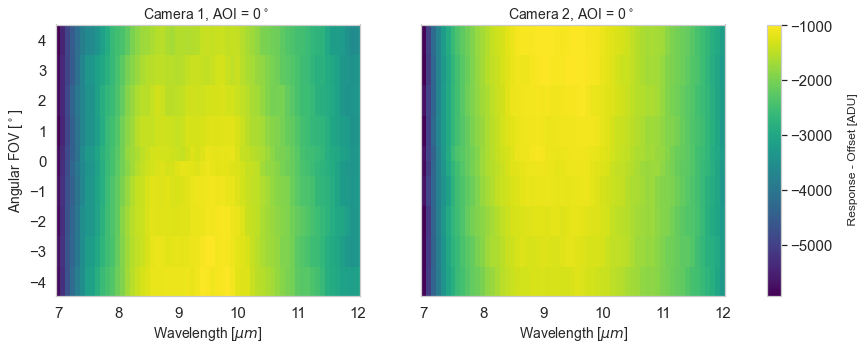

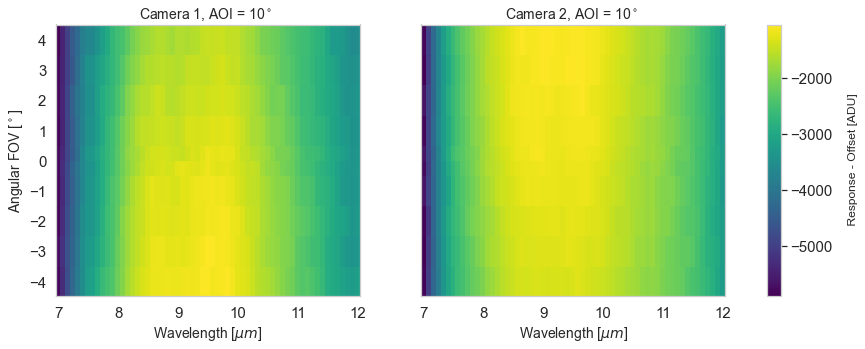

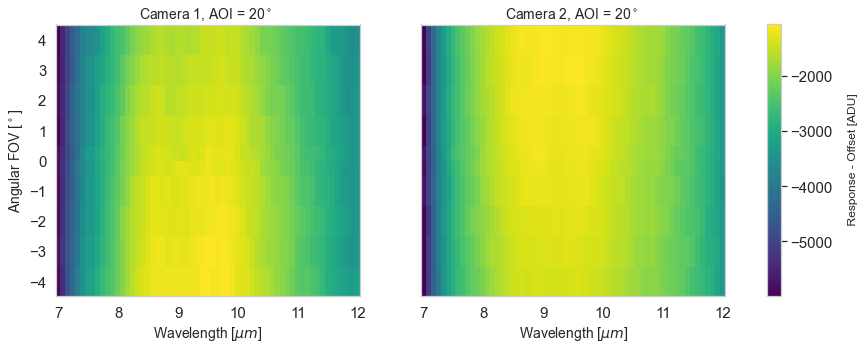

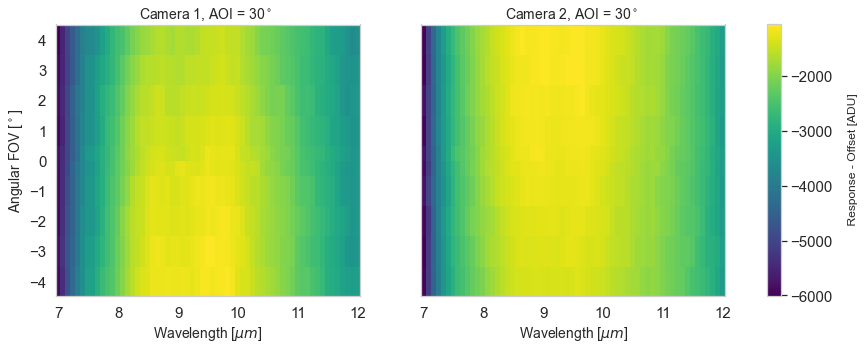

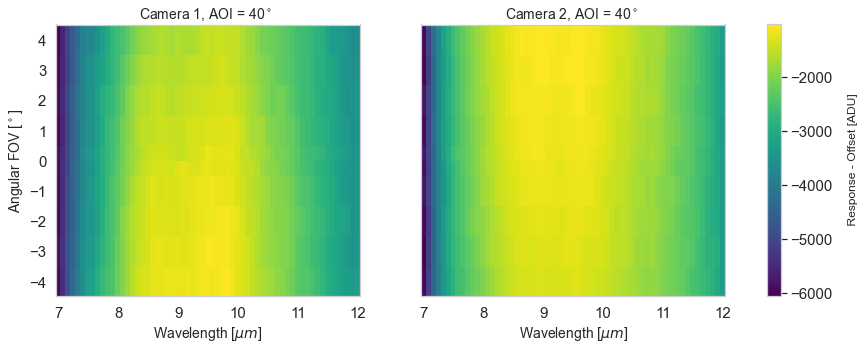

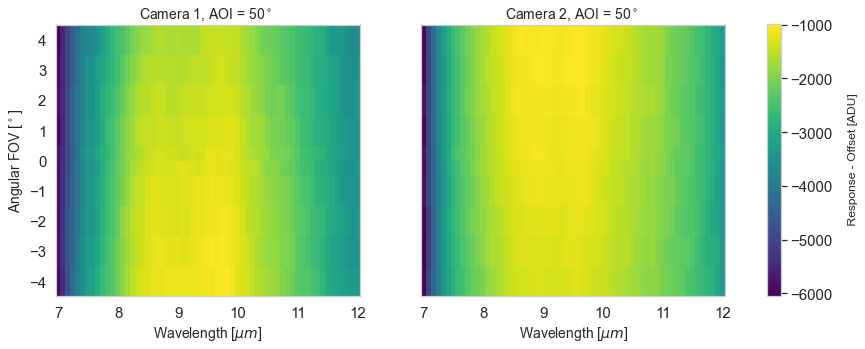

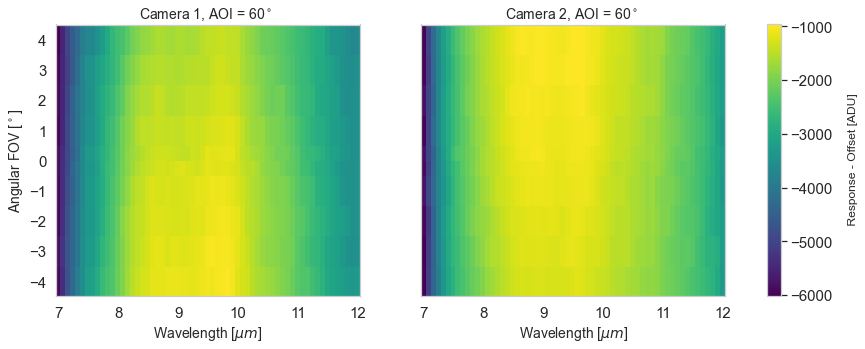

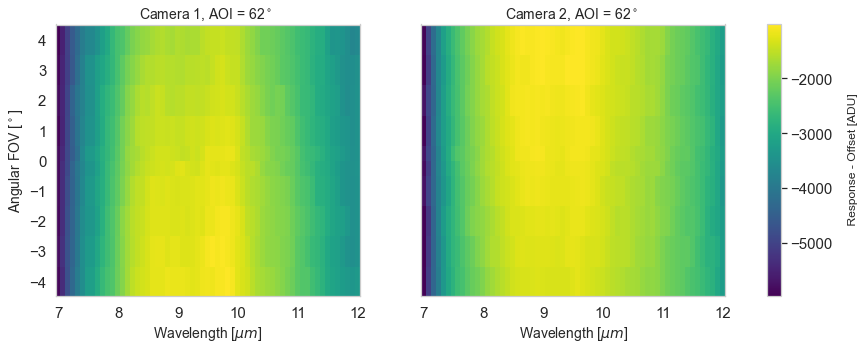

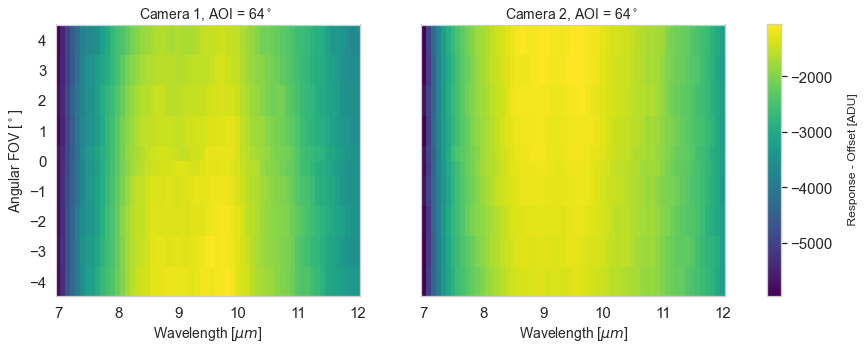

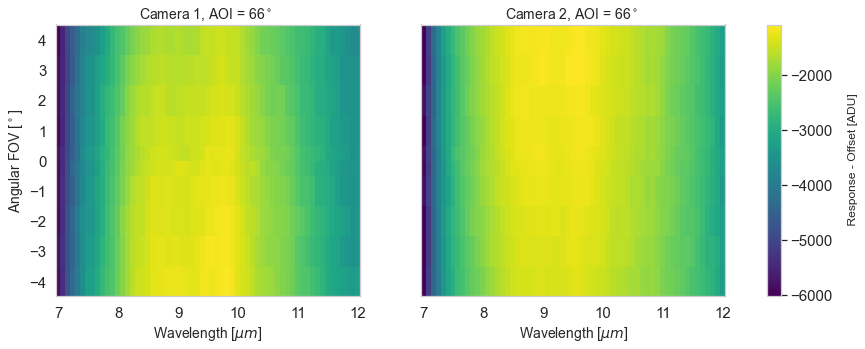

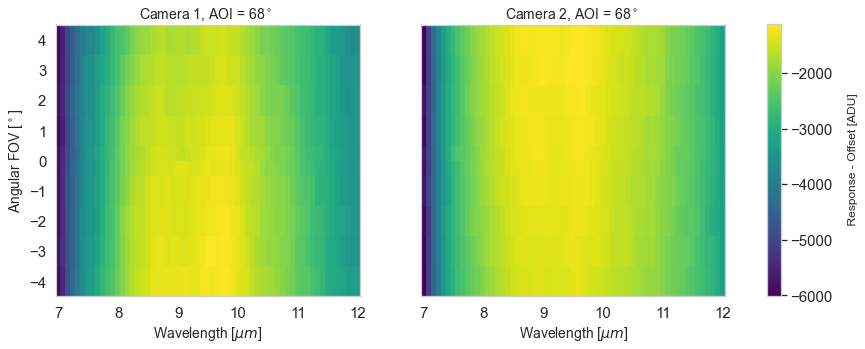

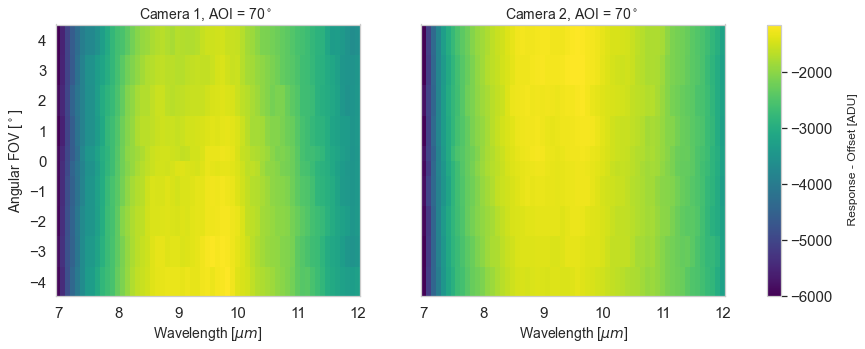

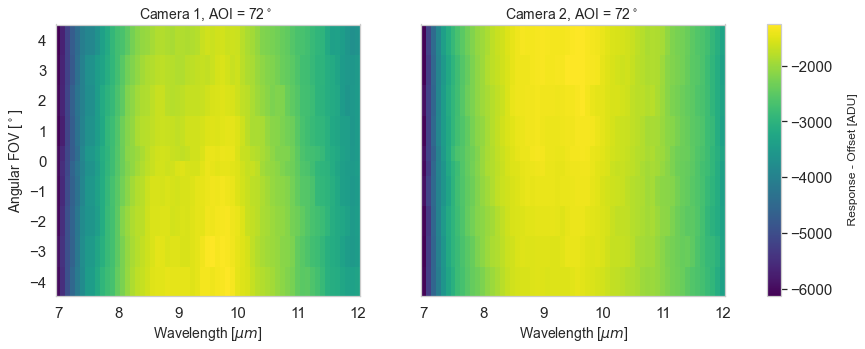

In [121]:
spath = '/Volumes/KESU/mar26/Ge/'
X,Y = np.meshgrid(waves,angles[25:35])
for j in range(len(lps)):

    I1 = (dfn['ims1'][j][35:45]-B1[35:45])/transmission1
    I2 = (dfn['ims2'][j][20:30]-B2[20:30])/transmission2 

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =True)

    pl1 = axes[0].pcolormesh(X,Y,I1 ,shading ='auto' ,cmap = "viridis")
    #pl1.set_clim([2000,16000])
    axes[0].set_ylabel('Angular FOV [$^\circ$]')
    axes[0].set_xlabel('Wavelength [$\mu m$]')
    axes[0].set_title('Camera 1, AOI = ' + str(lps[j])+ '$ ^\circ $ ')


    pl2 = axes[1].pcolormesh(X,Y,I2,shading ='auto' ,cmap = "viridis")
    #pl2.set_clim([2000,16000])
    axes[1].set_xlabel('Wavelength [$\mu m$]')
    axes[1].set_title('Camera 2, AOI = ' + str(lps[j])+ '$ ^\circ $ ')

    cbar = fig.colorbar(pl1, ax=axes.ravel().tolist())
    cbar.ax.set_ylabel('\n Response - Offset [ADU]',fontsize = 12)
    
    fig.savefig(spath +'plot'+str(j)+'.png')

In [39]:
'''animate'''
import imageio
from pathlib import Path

image_path = Path(spath)
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite(spath +'images.gif', image_list,fps = 0.5)    

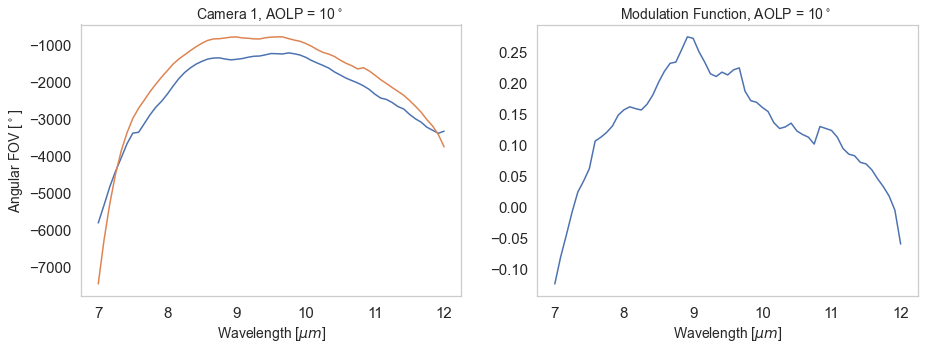

In [123]:
j = 1;

I1 = (dfn['ims1'][j][35:45]-B1[35:45])/transmission1
I2 = (dfn['ims2'][j][20:30]-B2[20:30])/transmission2 


mod = (I1-I2)/(I1+I2)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =False)

axes[0].plot(waves,np.mean(I1,0))
axes[0].plot(waves,np.mean(I2,0))
axes[0].set_ylabel('Angular FOV [$^\circ$]')
axes[0].set_xlabel('Wavelength [$\mu m$]')
axes[0].set_title('Camera 1, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')


pl2 = axes[1].plot(waves,np.mean(mod,0))
axes[1].set_xlabel('Wavelength [$\mu m$]')
axes[1].set_title('Modulation Function, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')

plt.show()

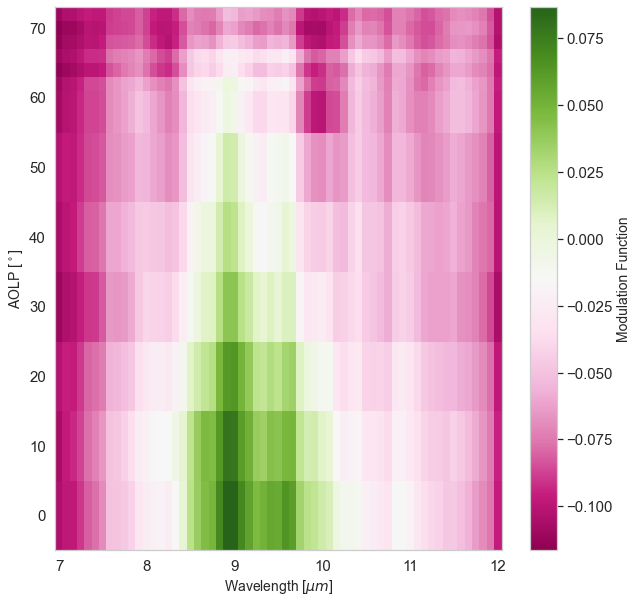

In [124]:
F1 = np.zeros([len(lps),61])
for j in range(len(lps)):
    f1 = np.mean(dfn['ims1'][j][35:45]-B1[35:45],0)
    f2 = np.mean(dfn['ims2'][j][20:30]-B2[20:30],0)
    F1[j] =(f1-f2)/(f1+f2)
X,Y = np.meshgrid(waves,lps)
plt.pcolormesh(X,Y,F1 - .15,shading ='auto' ,cmap = "PiYG")
plt.ylabel('AOLP [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.colorbar(label = "Modulation Function")
plt.show()

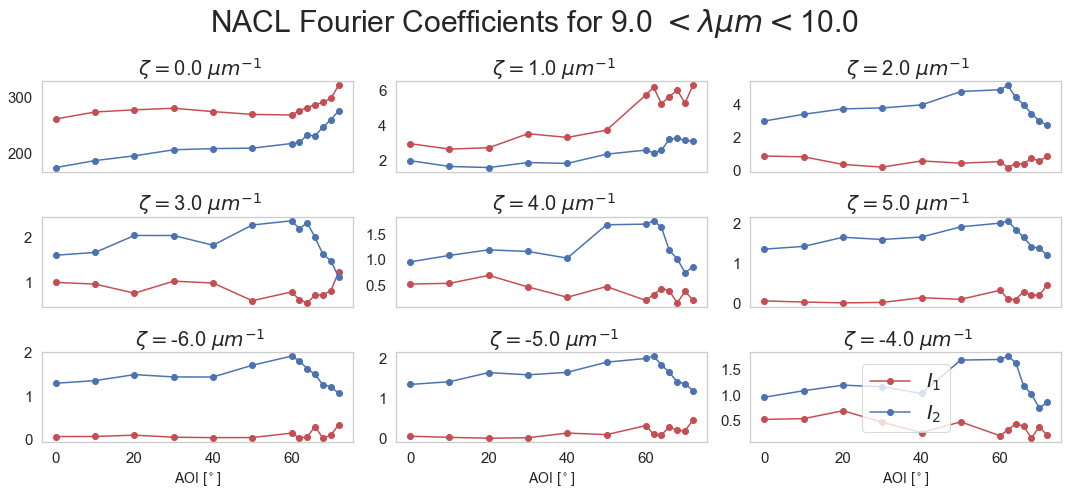

In [125]:
lstart = 0  + 24;
lstop  = 12 + 24;
dt = waves[1]-waves[0]
freq = np.fft.fftfreq(lstop-lstart, dt)

coef_re1   = np.zeros([len(lps),len(freq)]);
coef_re2   = np.zeros([len(lps),len(freq)]);


for j in range(len(lps)):

    f1 = np.mean(dfn['ims1'][j][35:45]-B1[35:45],0)[lstart:lstop]
    f2 = np.mean(dfn['ims2'][j][20:30]-B2[20:30],0)[lstart:lstop]
    f = (f1-f2)/(f1+f2)
    
    # perform FT and multiply by dt
    ft1 = np.fft.fft(f1) * dt
    ft2 = np.fft.fft(f2) * dt
    
    coef_re1[j] = np.abs(ft1)
    coef_re2[j] = np.abs(ft2)
plt.show()    


fig, axes = plt.subplots(ncols= 3,nrows = 3 ,figsize=(15, 7), tight_layout=True ,sharey =False,sharex = True)
coefs = [[0,1,2],[3,4,5],[6,7,8]]
for j in range(3):
    for i in range(3):
        axes[i][j].plot(lps, coef_re1[:,coefs[i][j]],'ro-',label = '$I_1$')
        axes[i][j].plot(lps, coef_re2[:,coefs[i][j]],'bo-',label = '$I_2$')
        axes[i][j].set_title(" $\zeta = $"+ str(np.round(freq[coefs[i][j]],2))+ ' $\mu m^{-1}$',fontsize = 20)
        
            
        if i ==2:
            axes[i][j].set_xlabel('AOI [$^\circ$]')
            if j == 2:
                axes[i][j].legend(fontsize = 20)

fig.suptitle('NACL Fourier Coefficients for ' + str(round(waves[lstart],2)) +" $ < \lambda \mu m < $"+ str(round(waves[lstop],2)),fontsize =30)
plt.show()


In [126]:
lstart = 0 + 1*12;
lstop  = 12+ 1*12;

dt = waves[1]-waves[0]
freq = np.fft.fftfreq(lstop-lstart, dt)

coef_re1   = np.zeros([len(lps),len(freq)]);
coef_re2   = np.zeros([len(lps),len(freq)]);
coef_im1   = np.zeros([len(lps),len(freq)]);
coef_im2   = np.zeros([len(lps),len(freq)]);


for j in range(len(lps)):

    f1 = np.mean(dfn['ims1'][j][27:47] -b1,0)[lstart:lstop]
    f2 = np.mean(dfn['ims2'][j][20:40] -b2,0)[lstart:lstop]
    f = (f1-f2)/(f1+f2)
    
    # perform FT and multiply by dt
    ft1 = np.fft.fft(f1) * dt
    ft2 = np.fft.fft(f2) * dt
    
    coef_re1[j] = np.real(ft1)
    coef_re2[j] = np.real(ft2)
    coef_im1[j] = np.imag(ft1)
    coef_im2[j] = np.imag(ft2)


fig, axes = plt.subplots(ncols= 3,nrows = 2 ,figsize=(15, 7), tight_layout=True ,sharey =False,sharex = True)
coefs = [[0,1,2],[0,1,2]]
for j in range(3):
    i = 0;
    axes[i][j].set_title(" $\zeta = $"+ str(np.round(freq[coefs[i][j]],2))+ ' $\mu m^{-1}$',fontsize = 20)
    if j ==0:
        axes[i][j].set_ylabel('Real',fontsize = 20)
        axes[i][j].plot(lps, coef_re1[:,coefs[i][j]],'ro-',label = '$I_1$')
        axes[i][j].plot(lps, coef_re2[:,coefs[i][j]],'bo-',label = '$I_2$')
    else:
        axes[i][j].plot(lps, coef_re1[:,coefs[i][j]]/coef_re1[:,coefs[0][0]],'ro-',label = '$I_1$')
        axes[i][j].plot(lps, coef_re2[:,coefs[i][j]]/coef_re2[:,coefs[0][0]],'bo-',label = '$I_2$')
        
    
    i = 1;
    axes[i][j].plot(lps, coef_im1[:,coefs[i][j]]/coef_re1[:,coefs[0][0]],'ro--',label = '$I_1$')
    axes[i][j].plot(lps, coef_im2[:,coefs[i][j]]/coef_re2[:,coefs[0][0]],'bo--',label = '$I_2$')
    
        
    axes[i][j].set_xlabel('AOI [$^\circ$]')
    if j == 0:
        axes[i][j].legend(fontsize = 20)
        axes[i][j].set_ylabel('Imaginary',fontsize = 20)    
            
fig.suptitle('Fourier Coefficients for ' + str(round(waves[lstart],2)) +" $ < \lambda \mu m < $"+ str(round(waves[lstop],2)),fontsize =30)
plt.show()


ValueError: operands could not be broadcast together with shapes (20,61) (256,320) 

In [98]:
c11 =[]
c21 =[]
i11 =[]
i21 =[]
coef = 0

center = []
for delta_l in range(50):
    lstart = 0  + delta_l;
    lstop  = 12 + delta_l;

    center.append(round(waves[int(6 + delta_l)],2))
    dt = waves[1]-waves[0]
    freq = np.fft.fftfreq(lstop-lstart, dt)

    coef_re1   = np.zeros(len(lps));
    coef_re2   = np.zeros(len(lps));
    coef_im1   = np.zeros(len(lps));
    coef_im2   = np.zeros(len(lps));

    for j in range(len(lps)):

        f1 = np.mean(dfn['ims1'][j][27:47] -b1,0)[lstart:lstop]
        f2 = np.mean(dfn['ims2'][j][20:40] -b2,0)[lstart:lstop]

        # perform FT and multiply by dt
        ft1 = np.fft.fft(f1) * dt
        ft2 = np.fft.fft(f2) * dt

        coef_re1[j] = np.real(ft1[coef])
        coef_re2[j] = np.real(ft2[coef])
        coef_im1[j] = np.imag(ft1[coef])
        coef_im2[j] = np.imag(ft2[coef])

    c11.append(coef_re1)
    c21.append(coef_re2)
    i11.append(coef_im1)
    i21.append(coef_im2)

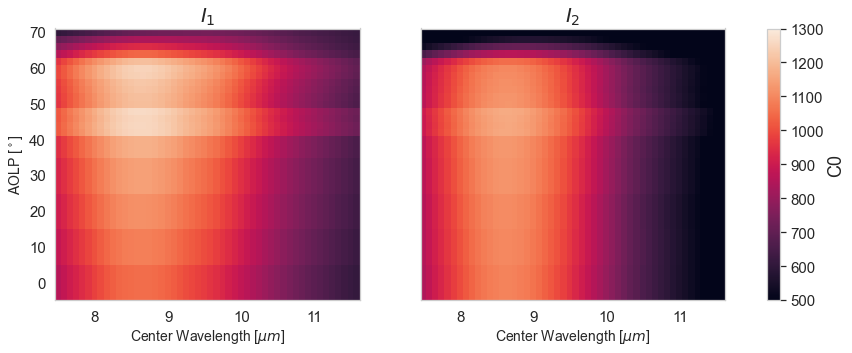

In [104]:
X,Y = np.meshgrid(center , lps)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5), tight_layout=False,sharey =True)

pl1 =axes[0].pcolormesh(X,Y,np.transpose(c11),shading = 'auto')
pl1.set_clim([500,1300])
pl2 =axes[1].pcolormesh(X,Y,np.transpose(c21),shading = 'auto')
pl2.set_clim([500,1300])

axes[0].set_ylabel('AOLP [$^\circ$]')
axes[0].set_xlabel('Center Wavelength [$\mu m$]')
axes[0].set_title('$I_1$',fontsize = 20)


axes[1].set_xlabel('Center Wavelength [$\mu m$]')
axes[1].set_title('$I_2$',fontsize = 20)

cbar = fig.colorbar(pl1, ax=axes.ravel().tolist())
cbar.ax.set_ylabel('C'+str(coef),fontsize = 18)
plt.show()